In [66]:
from google.cloud import bigquery
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [2]:
client = bigquery.Client(project='product-analytics-portfolio')

#### Prepping for the initial data pipeline

Writing a query to determine if a user EVER converted, regardless of date or session

In [3]:
event_query = """WITH stacked_table AS (SELECT event_date,
        event_timestamp,
        user_pseudo_id,
        event_name
    FROM `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_20210130`
    WHERE event_name IN ('page_view', 'add_to_cart',
    'begin_checkout', 'purchase')
UNION ALL
    SELECT event_date,
        event_timestamp,
        user_pseudo_id,
        event_name
    FROM `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_20210131`
    WHERE event_name IN ('page_view', 'add_to_cart',
    'begin_checkout', 'purchase')
UNION ALL
    SELECT event_date,
        event_timestamp,
        user_pseudo_id,
        event_name
    FROM `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_20210129`
    WHERE event_name IN ('page_view', 'add_to_cart',
    'begin_checkout', 'purchase')),

flagged_events AS (SELECT *,
       CASE WHEN event_name = 'page_view' THEN 1 ELSE 0 END AS page_view,
       CASE WHEN event_name = 'add_to_cart' THEN 1 ELSE 0 END AS add_to_cart,
       CASE WHEN event_name = 'begin_checkout' THEN 1 ELSE 0 END as begin_checkout,
       CASE WHEN event_name = 'purchase' THEN 1 ELSE 0 END as purchase
FROM stacked_table)

SELECT user_pseudo_id,
       MIN(event_date) AS first_event_date,
       MIN(event_timestamp) AS first_event_timestamp,
       CASE WHEN SUM(page_view) > 0 THEN 1 ELSE 0 END viewed_page,
       CASE WHEN SUM(add_to_cart) > 0 THEN 1 ELSE 0 END added_to_cart,
       CASE WHEN SUM(begin_checkout) > 0 THEN 1 ELSE 0 END began_checkout,
       CASE WHEN SUM(purchase) > 0 THEN 1 ELSE 0 END purchased
FROM flagged_events
GROUP BY user_pseudo_id;"""
event_results = client.query(event_query).to_dataframe()

/Users/samueljoseph/Documents/Programming/ecommerce-funnel-analysis/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [16]:
long_events = event_results.copy().melt(id_vars = ['user_pseudo_id', 'first_event_date', 'first_event_timestamp'])\
.rename(columns = {'variable': 'event', 'value': 'occurence'})

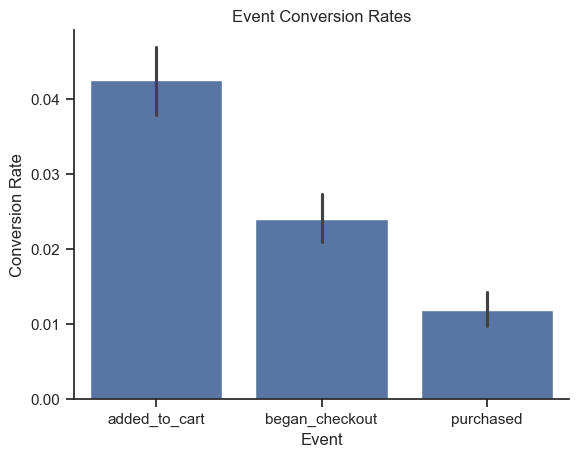

In [34]:
sns.barplot(x = 'event',
            y = 'occurence',
            data = long_events[long_events['event'] != 'viewed_page'])
plt.title('Event Conversion Rates')
plt.ylabel('Conversion Rate')
plt.xlabel('Event')
plt.show()

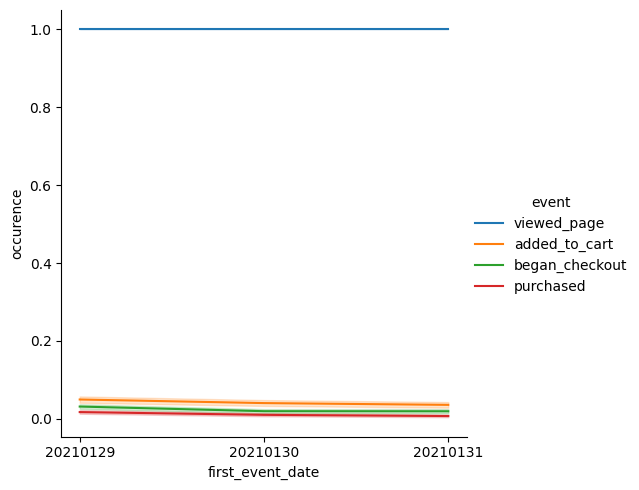

In [ ]:
# Plotting true conversion rates (% over total)
sns.relplot(data = long_events,
            x = 'first_event_date',
            y = 'occurence',
            hue = 'event',
            kind = 'line')
plt.show()

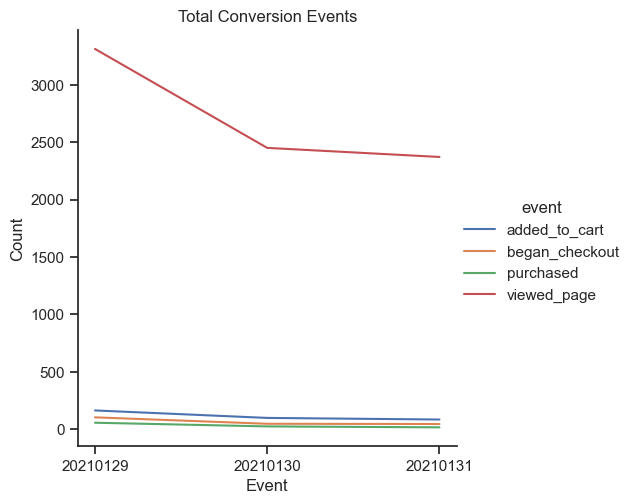

In [36]:
# Plotting total page views and conversion
agg_long_events = long_events.loc[:, ['first_event_date', 'event', 'occurence']]\
    .groupby(['first_event_date', 'event']).sum().reset_index()

# Setting the theme
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

sns.relplot(data = agg_long_events,
            x = 'first_event_date',
            y = 'occurence',
            hue = 'event',
            kind = 'line')
plt.title('Total Conversion Events')
plt.ylabel('Count')
plt.xlabel('Event')
plt.show()

Writing a query to determine intra-session conversion

In [ ]:
session_sql = """-- CTE to stack relevant columns from two date tables
-- Needs to be compressed to query across all tables with a wildcard for production
WITH stacked_table AS (SELECT DISTINCT user_pseudo_id,
      event_date,
      event_timestamp, 
      events.value.int_value AS session,
      event_name
FROM `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_20210130`,
     UNNEST(event_params) AS events
WHERE event_name IN ('page_view', 'add_to_cart', 'begin_checkout', 'purchase') AND
      events.key = 'ga_session_id'
UNION ALL
SELECT DISTINCT user_pseudo_id,
      event_date,
      event_timestamp, 
      events.value.int_value AS session,
      event_name
FROM `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_20210130`,
     UNNEST(event_params) AS events
WHERE event_name IN ('page_view', 'add_to_cart', 'begin_checkout', 'purchase') AND
      events.key = 'ga_session_id'),

-- CTE to create flagged events by user and session
flagged_events AS (SELECT *,
       CASE WHEN event_name = 'page_view' THEN 1 ELSE 0 END AS page_view,
       CASE WHEN event_name = 'add_to_cart' THEN 1 ELSE 0 END AS add_to_cart,
       CASE WHEN event_name = 'begin_checkout' THEN 1 ELSE 0 END as begin_checkout,
       CASE WHEN event_name = 'purchase' THEN 1 ELSE 0 END as purchase
FROM stacked_table)

-- Getting aggregated values by session and user
SELECT user_pseudo_id,
       session,
       MIN(event_date) AS first_event_date,
       MIN(event_timestamp) AS first_event_timestamp,
       CASE WHEN SUM(page_view) > 0 THEN 1 ELSE 0 END viewed_page,
       CASE WHEN SUM(add_to_cart) > 0 THEN 1 ELSE 0 END added_to_cart,
       CASE WHEN SUM(begin_checkout) > 0 THEN 1 ELSE 0 END began_checkout,
       CASE WHEN SUM(purchase) > 0 THEN 1 ELSE 0 END purchased
FROM flagged_events
GROUP BY user_pseudo_id, session;"""
session_query = client.query(session_sql).to_dataframe()

In [ ]:
long_session = session_query.melt(
            id_vars=['user_pseudo_id',
                     'session',
                     'first_event_date',
                     'first_event_timestamp'])\
            .rename(columns={'variable': 'event', 'value': 'occurence'})

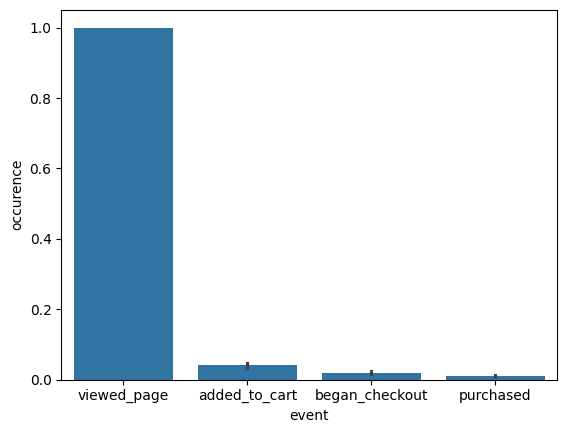

In [8]:
sns.barplot(x = 'event',
            y = 'occurence',
            data = long_session)
plt.show()

#### Segmentation Queries

Query for device information

In [5]:
device_sql = """SELECT DISTINCT user_pseudo_id,
       events.value.int_value AS session,
       device.category,
       device.mobile_brand_name,
       device.operating_system
FROM `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_20210131`,
     UNNEST(event_params) AS events
WHERE events.key = 'ga_session_id'"""

In [ ]:
geo_sql = """SELECT DISTINCT user_pseudo_id,
       events.value.int_value AS session,
       geo.continent,
       geo.country,
       geo.region,
       geo.city
FROM `bigquery-public-data.ga4_obfuscated_sample_ecommerce.events_20210131`,
     UNNEST(event_params) AS events
WHERE events.key = 'ga_session_id'"""

/Users/samueljoseph/Documents/Programming/ecommerce-funnel-analysis/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [ ]:
device_query = client.query(device_sql).to_dataframe()
geo_query = client.query(geo_sql).to_dataframe()

/Users/samueljoseph/Documents/Programming/ecommerce-funnel-analysis/.venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


#### Code to workshop clustering

In [61]:
clustering_df = event_results.loc[:, ['user_pseudo_id', 'first_event_date']]\
    .merge(geo_query.loc[:, ['user_pseudo_id', 'continent', 'country', 'region']])

clustering_df['first_event_date'] = pd.to_datetime(clustering_df['first_event_date'])

country_counts = clustering_df['country'].value_counts()
clustering_df['country_map'] = clustering_df['country'].apply(lambda x: x if country_counts[x] > 20 else 'Other')

region_counts = clustering_df['region'].value_counts()
clustering_df['region_map'] = clustering_df['region'].apply(lambda x: x if region_counts[x] > 20 else 'Other')
clust_df = clustering_df.set_index('user_pseudo_id').loc[:, ['first_event_date', 'country_map', 'region_map']]

In [63]:
prepped_cluster_df = pd.get_dummies(clust_df, columns = ['country_map', 'region_map', 'first_event_date'], dtype=int)

In [67]:
k_means = KMeans(n_clusters=5)
k_means.fit(prepped_cluster_df)

,n_clusters,5
,init,'k-means++'
,n_init,'auto'
,max_iter,300
,tol,0.0001
,verbose,0
,random_state,None
,copy_x,True
,algorithm,'lloyd'


In [73]:
clustering_df['cluster'] = k_means.fit_predict(prepped_cluster_df)